In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
directory = '/Users/mrinaalarora/Downloads/Spotify Extended Streaming History'
dataframes = []

for filename in os.listdir(directory):
    if filename.endswith('.json'):
        filepath = os.path.join(directory, filename)
        df = pd.read_json(filepath)
        dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.to_json('spotify_data.json', orient='records', lines=True)

In [ ]:
my_data = pd.read_json('data/spotify_data.json',lines=True)
my_data

In [ ]:
# Data Preparation and Cleaning
relevant_columns = [ "ts", "platform", "ms_played", "conn_country", "master_metadata_track_name", "master_metadata_album_artist_name", "master_metadata_album_album_name", "shuffle", "skipped", "offline", "incognito_mode" ]
spotify_stream_df = my_data[relevant_columns]
spotify_stream_df # to read all the dataframe at once

In [ ]:
# Number of unique artists
unique_artists = spotify_stream_df['master_metadata_album_artist_name'].nunique()
print(f"Number of unique artists: {unique_artists}")

In [ ]:
# Number of unique tracks
unique_tracks = spotify_stream_df['master_metadata_track_name'].nunique()
print(f"Number of unique tracks: {unique_tracks}")

In [ ]:
# Converting 'ts' to datetime
spotify_stream_df['Play-Time'] = pd.to_datetime(spotify_stream_df['ts'])

# Extract year, month, day, weekday, time, hour, day_name
spotify_stream_df['year'] = pd.DatetimeIndex(spotify_stream_df["Play-Time"]).year
spotify_stream_df['month'] = pd.DatetimeIndex(spotify_stream_df["Play-Time"]).month
spotify_stream_df['day'] = pd.DatetimeIndex(spotify_stream_df["Play-Time"]).day
spotify_stream_df['weekday'] = pd.DatetimeIndex(spotify_stream_df["Play-Time"]).weekday
spotify_stream_df['time'] = pd.DatetimeIndex(spotify_stream_df["Play-Time"]).time
spotify_stream_df['hours'] = pd.DatetimeIndex(spotify_stream_df["Play-Time"]).hour
spotify_stream_df['day-name'] = spotify_stream_df["Play-Time"].apply(lambda x: x.day_name())

# Add Count column
spotify_stream_df['Count'] = 1

# Convert milliseconds played to timedeltas
spotify_stream_df["Time-Played (hh-mm-ss)"] = pd.to_timedelta(spotify_stream_df["ms_played"], unit='ms')

# Functions to extract hours and minutes from timedeltas
def hours(td):
    '''To get the hour information'''
    return td.seconds / 3600

def minutes(td):
    '''To get the minutes information'''
    return (td.seconds / 60) % 60

# Apply functions to extract listening time in hours and minutes
spotify_stream_df["Listening Time (Hours)"] = spotify_stream_df["Time-Played (hh-mm-ss)"].apply(hours).round(3)
spotify_stream_df["Listening Time (Minutes)"] = spotify_stream_df["Time-Played (hh-mm-ss)"].apply(minutes).round(3)
spotify_stream_df.sample(3)

In [ ]:
columns_to_drop = ['ts','ms_played','Time-Played (hh-mm-ss)']
spotify_stream_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Display a sample of the DataFrame to verify the correct columns have been removed
spotify_stream_df

In [ ]:
# Percentage of Unique Artists

unique_artists = spotify_stream_df["master_metadata_album_artist_name"].nunique()
total_artists = spotify_stream_df["master_metadata_album_artist_name"].count()
unique_artist_percentage = (unique_artists / total_artists) * 100

# Prepare data for the pie chart
unique_artist_list = np.array([unique_artists, total_artists - unique_artists])
unique_artist_list_labels = ["Unique Artists", "Non Unique Artists"]

# Create a pie chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.pie(unique_artist_list, labels=unique_artist_list_labels, autopct='%1.1f%%', explode=[0.05, 0.05], startangle=180, shadow=True)
plt.title("Unique Artist Percentage")
plt.show()

# Print the calculated percentages for reference
print(f"Number of unique artists: {unique_artists}")
print(f"Total number of artist entries: {total_artists}")
print(f"Percentage of unique artists: {unique_artist_percentage:.2f}%")

In [ ]:
# Group by artist name and calculate the sum of listening time and counts
top_artists_df = spotify_stream_df.groupby("master_metadata_album_artist_name")[["Listening Time (Hours)", "Listening Time (Minutes)", "Count"]].sum()

# Top 10 artists by Listening Time (Hours)
top_10_artists_hours = top_artists_df.sort_values(by="Listening Time (Hours)", ascending=False).head(10)
# Top 10 artists by Count
top_10_artists_count = top_artists_df.sort_values(by="Count", ascending=False).head(10)

# Visualization of top 10 unique artists by listening time (hours)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_artists_hours.index, y=top_10_artists_hours["Listening Time (Hours)"], palette='viridis')
plt.xlabel('Artists')
plt.ylabel('No. of Hours Songs Played')
plt.title('My Top 10 Favourite Artist (based on Hours)')
plt.xticks(rotation=45, ha='right')
plt.show()

# Visualization of top 10 unique artists by play count
plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_artists_count.index, y=top_10_artists_count["Count"], palette='magma')
plt.xlabel('Artists')
plt.ylabel('No. of Times Songs Played')
plt.title('My Top 10 Favourite Artist (based on Counts)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Calculate the number of unique tracks
unique_tracks = spotify_stream_df["master_metadata_track_name"].nunique()

# Calculating the total number of track entries
total_tracks = spotify_stream_df["master_metadata_track_name"].count()

# Calculate the percentage of unique tracks
unique_tracks_percentage = (unique_tracks / total_tracks) * 100

# Prepare data for the pie chart
unique_tracks_list = np.array([unique_tracks, total_tracks - unique_tracks])
unique_tracks_list_labels = ["Unique Tracks", "Non Unique Tracks"]

# Create a pie chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.pie(unique_tracks_list, labels=unique_tracks_list_labels, autopct='%1.1f%%', explode=[0.05, 0.05], startangle=180, shadow=True)
plt.title("Unique Tracks Percentage")
plt.show()

# Print the calculated percentages for reference
print(f"Number of unique tracks: {unique_tracks}")
print(f"Total number of track entries: {total_tracks}")
print(f"Percentage of unique tracks: {unique_tracks_percentage:.2f}%")

In [ ]:
top_tracks_df = spotify_stream_df.groupby("master_metadata_track_name")[["Listening Time (Hours)", "Listening Time (Minutes)", "Count"]].sum().sort_values(by="Count", ascending=False)

# Display the top 10 tracks by play count and listening time.
top_10_tracks = top_tracks_df.head(10)
top_10_tracks

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.pie(spotify_stream_df["day-name"].value_counts(), labels=spotify_stream_df["day-name"].value_counts().index, autopct='%1.1f%%', startangle=180, shadow = True);
ax.set(title="Day wise % of Spotify Streaming");

In [ ]:
# Average Usage over a day
fig, ax = plt.subplots(figsize=(12,8))
ax.set(title="Average Distribution of Streaming Over Day Hours",xlabel="Hours (in 24 hour format)", ylabel="Songs Played")
sns.histplot(spotify_stream_df["hours"], bins=24,kde=True, color="darkgreen");

In [ ]:
# Average Usage In a Year
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.countplot(y=spotify_stream_df["month"], ax=ax)
ax.set(title="Average Spotify Usage over Years", xlabel="Songs Played in Counts", ylabel="Months (1-12)");

In [ ]:
# Aggregate data by date
songs_per_day = spotify_stream_df.groupby(spotify_stream_df['Play-Time'].dt.date)['Count'].sum().reset_index()
songs_per_day.columns = ['Date', 'Number of Songs Played']

# Identify the day with maximum songs played
max_songs_day = songs_per_day[songs_per_day['Number of Songs Played'] == songs_per_day['Number of Songs Played'].max()]

print(f"The day with the maximum number of songs played is: {max_songs_day['Date'].values[0]} with {max_songs_day['Number of Songs Played'].values[0]} songs.")

# Plot a scatter plot to show all the dates
plt.figure(figsize=(12, 7))
sns.scatterplot(data=songs_per_day, x='Date', y='Number of Songs Played', hue='Number of Songs Played', palette='viridis', legend=None)
plt.title('Number of Songs Played Each Day')
plt.xlabel('Date')
plt.ylabel('Number of Songs Played')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
top_artists_df = top_artists_df.sort_values(by = 'Count', ascending = False)
# Selecting the top 100 artists
top_100_artists = top_artists_df.head(100)

# generating the wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_100_artists['Count'])
# Display the word cloud
plt.figure(figsize=(14, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Favorite Artists')
plt.show()

In [ ]:
# Extract day of the week and hour from 'Play-Time'
spotify_stream_df['day_of_week'] = spotify_stream_df['Play-Time'].dt.day_name()
spotify_stream_df['hour'] = spotify_stream_df['Play-Time'].dt.hour

# Aggregate data by day of the week and hour
usage_by_day_hour = spotify_stream_df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

# Reorder the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
usage_by_day_hour = usage_by_day_hour.reindex(days_order)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(usage_by_day_hour, cmap='Blues', annot=True, fmt='d', cbar_kws={'label': 'Number of Songs Played'})
plt.title('Spotify Usage (Active Usage in a Day Over a Week)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

/tmp/ipykernel_1663/3828593155.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_album_by_hours.index, y=top_10_album_by_hours["Listening Time (Hours)"], palette='viridis')


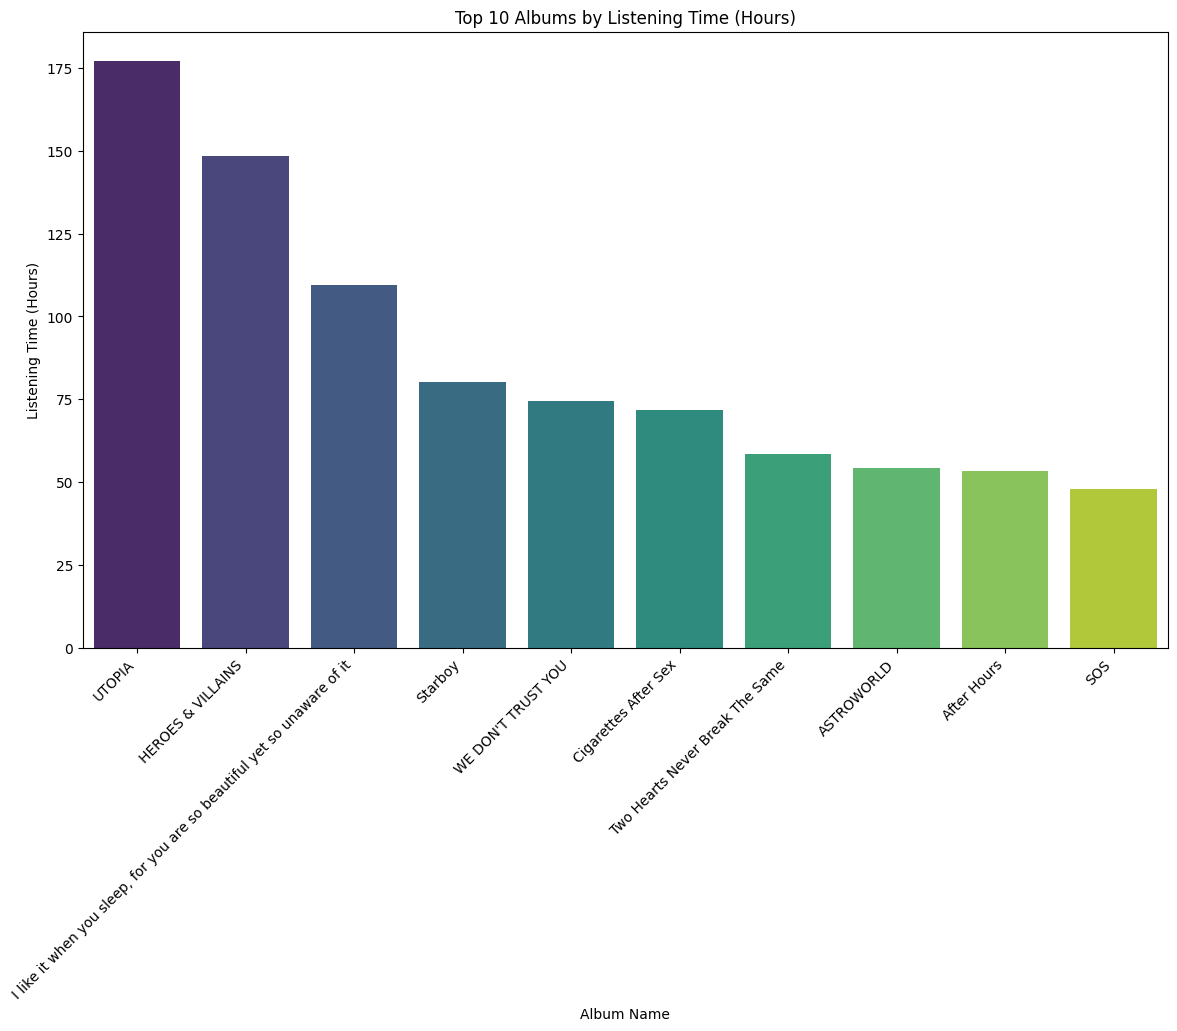

In [24]:
albums_by_hours_df = spotify_stream_df.groupby('master_metadata_album_album_name')[['Listening Time (Hours)']].sum().sort_values(by='Listening Time (Hours)',ascending=False)
top_10_album_by_hours = albums_by_hours_df.head(10)

# Print the top 10 albums by listening hours for reference
plt.figure(figsize=(14, 8))
sns.barplot(x=top_10_album_by_hours.index, y=top_10_album_by_hours["Listening Time (Hours)"], palette='viridis')
plt.xlabel('Album Name')
plt.ylabel('Listening Time (Hours)')
plt.title(f'Top 10 Albums by Listening Time (Hours)')
plt.xticks(rotation=45, ha='right')
plt.show()